In [1]:
import numpy as np
import pandas as pd
import datetime

from scipy import stats
import statsmodels.api as sm
# from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """
    В коллабе работает, локально нет, поэтому перенес реализацию из sklearn
    """
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            multioutput = None

    return np.average(output_errors, weights=multioutput)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
df = pd.read_csv('data/ads_hour.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y %H:%M')
df.head()

Date    ads
0 2017-08-03 00:00:00  49136
1 2017-08-03 01:00:00  46450
2 2017-08-03 02:00:00  46355
3 2017-08-03 03:00:00  43748
4 2017-08-03 04:00:00  42281

### Train test split (в test последние 30% наблюдений)

In [5]:
TEST_FRAC = 0.3

train_size = int(np.ceil(df.shape[0] * (1 - TEST_FRAC)))
train_df = df[:train_size]
test_df = df[train_size:]

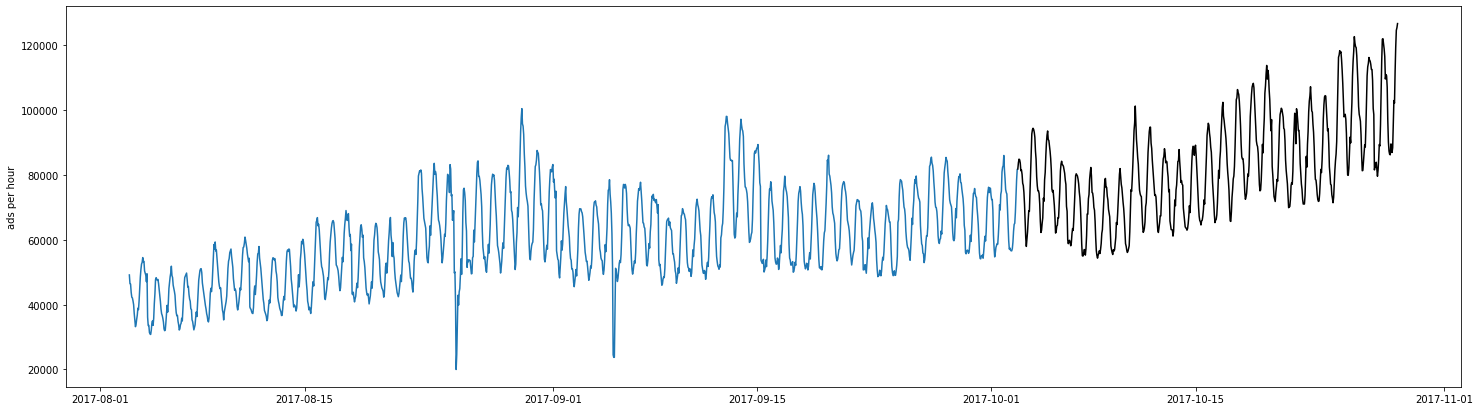

In [6]:
plt.figure(figsize=(25, 7))
plt.plot(train_df['Date'], train_df['ads'])
plt.plot(test_df['Date'], test_df['ads'], color='#000000')

plt.ylabel('ads per hour')
plt.show()

### Обучение модели

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_df['ads'].values.reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [8]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [9]:
train_inout_seq = create_inout_sequences(train_data_normalized, tw=24)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=3, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=3)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [11]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 20

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(3, 1, model.hidden_layer_size),
                        torch.zeros(3, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if not i%5:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   0 loss: 0.11477085
epoch:   5 loss: 0.00048844
epoch:  10 loss: 0.00006435
epoch:  15 loss: 0.00002517


### Прогноз для тестовой выборки

In [13]:
test_inputs = train_data_normalized[-24:].tolist()

for i in range(test_df.shape[0]):
    seq = torch.FloatTensor(test_inputs[-24:])
    with torch.no_grad():
        model.hidden = (torch.zeros(3, 1, model.hidden_layer_size),
                        torch.zeros(3, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [14]:
test_df['pred_lstm'] = scaler.inverse_transform(np.array(test_inputs[24:]).reshape(-1, 1))

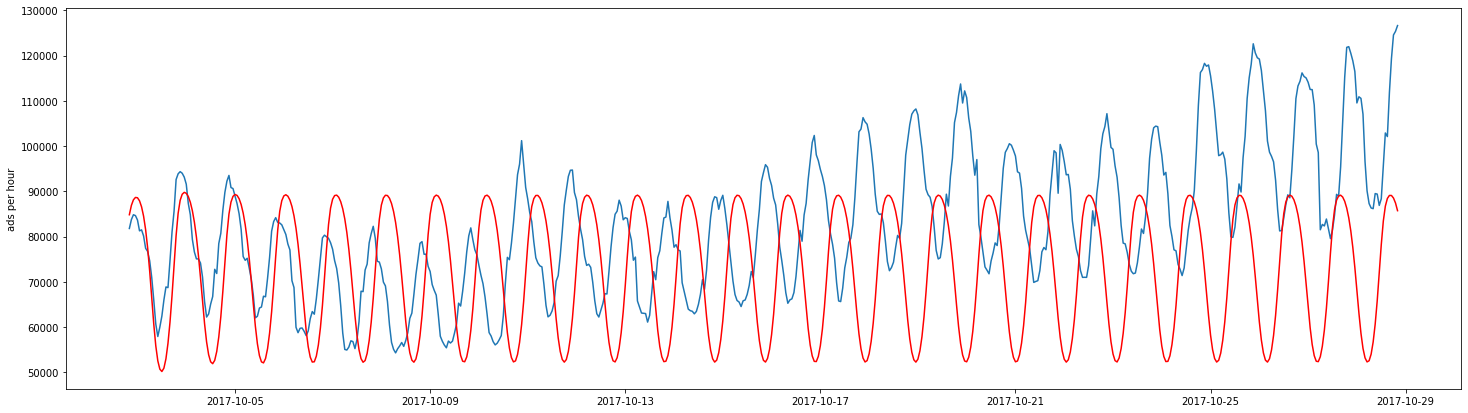

In [15]:
plt.figure(figsize=(25, 7))
plt.plot(test_df['Date'], test_df['ads'])
plt.plot(test_df['Date'], test_df['pred_lstm'], color='r')

plt.ylabel('ads per hour')
plt.show()

In [17]:
print(f"MAPE LSTM: {round(mean_absolute_percentage_error(test_df['ads'], test_df['pred_lstm']) * 100, 2)}%")

MAPE LSTM: 23.61%
